# Model Comparison

Tässä notebookissa vertaillaan eri koneoppimismalleja hydraulijärjestelmän tilan luokitteluun. Käytämme Support Vector Machine (SVM), Random Forest ja XGBoost -malleja.

## Kirjastojen lataus

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import pickle
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

## Datan lataus ja esikäsittely

In [3]:
def loadData():
    """
    Lataa training, validation ja test datat
    """
    currentDir = os.getcwd()
    dataDir = os.path.join(os.path.dirname(currentDir), 'Data')
    
    print("Ladataan datat...")
    trainingData = pd.read_csv(os.path.join(dataDir, 'trainingData.csv'))
    validationData = pd.read_csv(os.path.join(dataDir, 'validationData.csv'))
    testData = pd.read_csv(os.path.join(dataDir, 'testData.csv'))
    
    xTrain = trainingData[['pumpControl', 'pressure']]
    yTrain = trainingData['state']
    
    xVal = validationData[['pumpControl', 'pressure']]
    yVal = validationData['state']
    
    xTest = testData[['pumpControl', 'pressure']]
    yTest = testData['state']
    
    labelEncoder = LabelEncoder()
    yTrainEncoded = labelEncoder.fit_transform(yTrain)
    yValEncoded = labelEncoder.transform(yVal)
    yTestEncoded = labelEncoder.transform(yTest)
    
    classNames = labelEncoder.classes_
    
    print(f"Training data: {xTrain.shape[0]} riviä")
    print(f"Validation data: {xVal.shape[0]} riviä")
    print(f"Test data: {xTest.shape[0]} riviä")
    print(f"Luokat: {classNames.tolist()}")
    
    return xTrain, yTrainEncoded, xVal, yValEncoded, xTest, yTestEncoded, classNames

xTrain, yTrain, xVal, yVal, xTest, yTest, classNames = loadData()

Ladataan datat...
Training data: 6946 riviä
Validation data: 1489 riviä
Test data: 1489 riviä
Luokat: ['hose_break', 'normal_digging', 'normal_empty', 'normal_full', 'overload']


## Mallien optimointi
SVM:n optimointi

In [4]:
def optimizeSvm(xTrain, yTrain, xVal, yVal):
    """
    Optimoi SVM-mallin hyperparametrit
    """
    paramGrid = {
        'C': [1, 10, 50, 100, 200],
        'gamma': ['scale', 'auto', 0.1, 0.01],
        'kernel': ['rbf', 'poly']
    }
    
    svm = SVC(random_state=42)
    gridSearch = GridSearchCV(svm, paramGrid, cv=5, scoring='accuracy', n_jobs=-1)
    gridSearch.fit(xTrain, yTrain)
    
    bestParams = gridSearch.best_params_
    print(f"Parhaat hyperparametrit: {bestParams}")
    print(f"Paras CV-tarkkuus: {gridSearch.best_score_:.4f}")
    
    bestSvm = gridSearch.best_estimator_
    valAccuracy = bestSvm.score(xVal, yVal)
    print(f"Validointitarkkuus: {valAccuracy:.4f}")
    
    return bestSvm, valAccuracy, bestParams

bestSvm, svmValAccuracy, svmBestParams = optimizeSvm(xTrain, yTrain, xVal, yVal)

Parhaat hyperparametrit: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Paras CV-tarkkuus: 0.9901
Validointitarkkuus: 0.9899


## Random Forestin optimointi

In [5]:
def optimizeRandomForest(xTrain, yTrain, xVal, yVal):
    """
    Optimoi Random Forest -mallin hyperparametrit
    """
    paramGrid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 15, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    rf = RandomForestClassifier(random_state=42)
    gridSearch = GridSearchCV(rf, paramGrid, cv=5, scoring='accuracy', n_jobs=-1)
    gridSearch.fit(xTrain, yTrain)
    
    bestParams = gridSearch.best_params_
    print(f"Parhaat hyperparametrit: {bestParams}")
    print(f"Paras CV-tarkkuus: {gridSearch.best_score_:.4f}")
    
    bestRf = gridSearch.best_estimator_
    valAccuracy = bestRf.score(xVal, yVal)
    print(f"Validointitarkkuus: {valAccuracy:.4f}")
    
    return bestRf, valAccuracy, bestParams

bestRf, rfValAccuracy, rfBestParams = optimizeRandomForest(xTrain, yTrain, xVal, yVal)

Parhaat hyperparametrit: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Paras CV-tarkkuus: 0.9895
Validointitarkkuus: 0.9872


## XGBoostin optimointi

In [6]:
def optimizeXgboost(xTrain, yTrain, xVal, yVal):
    """
    Optimoi XGBoost-mallin hyperparametrit
    """
    paramGrid = {
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'n_estimators': [100, 200, 300],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }
    
    xgb = XGBClassifier(random_state=42, eval_metric='mlogloss')
    gridSearch = GridSearchCV(xgb, paramGrid, cv=5, scoring='accuracy', n_jobs=-1)
    gridSearch.fit(xTrain, yTrain)
    
    bestParams = gridSearch.best_params_
    print(f"Parhaat hyperparametrit: {bestParams}")
    print(f"Paras CV-tarkkuus: {gridSearch.best_score_:.4f}")
    
    bestXgb = gridSearch.best_estimator_
    valAccuracy = bestXgb.score(xVal, yVal)
    print(f"Validointitarkkuus: {valAccuracy:.4f}")
    
    return bestXgb, valAccuracy, bestParams

bestXgb, xgbValAccuracy, xgbBestParams = optimizeXgboost(xTrain, yTrain, xVal, yVal)

Parhaat hyperparametrit: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1.0}
Paras CV-tarkkuus: 0.9899
Validointitarkkuus: 0.9893


## Mallien arviointi

In [7]:
def evaluateModel(model, xTest, yTest, modelName, classNames):
    """
    Arvioi mallin suorituskyky testidatalla
    """
    yPred = model.predict(xTest)
    accuracy = accuracy_score(yTest, yPred)
    confMatrix = confusion_matrix(yTest, yPred)
    classReport = classification_report(yTest, yPred, target_names=classNames)
    
    print(f"Tarkkuus: {accuracy:.4f}")
    print("\nLuokitteluraportti:")
    print(classReport)
    
    return {
        'accuracy': accuracy,
        'confusionMatrix': confMatrix,
        'classificationReport': classReport
    }

svmResults = evaluateModel(bestSvm, xTest, yTest, "SVM", classNames)
rfResults = evaluateModel(bestRf, xTest, yTest, "Random Forest", classNames)
xgbResults = evaluateModel(bestXgb, xTest, yTest, "XGBoost", classNames)

Tarkkuus: 0.9906

Luokitteluraportti:
                precision    recall  f1-score   support

    hose_break       1.00      0.98      0.99       149
normal_digging       0.99      0.99      0.99       549
  normal_empty       1.00      1.00      1.00       166
   normal_full       0.94      0.98      0.96       180
      overload       1.00      1.00      1.00       445

      accuracy                           0.99      1489
     macro avg       0.99      0.99      0.99      1489
  weighted avg       0.99      0.99      0.99      1489

Tarkkuus: 0.9913

Luokitteluraportti:
                precision    recall  f1-score   support

    hose_break       1.00      0.98      0.99       149
normal_digging       1.00      0.99      0.99       549
  normal_empty       1.00      1.00      1.00       166
   normal_full       0.94      0.99      0.96       180
      overload       1.00      1.00      1.00       445

      accuracy                           0.99      1489
     macro avg       0.

## Mallien tallennus

In [9]:
def saveModel(model, modelName):
    """
    Tallenna malli tiedostoon
    """
    # Määritä tallennushakemisto
    modelsDir = os.path.join(os.path.dirname(os.getcwd()), 'Models')
    
    # Luo hakemisto, jos sitä ei ole olemassa
    if not os.path.exists(modelsDir):
        os.makedirs(modelsDir)
    
    # Tallenna malli
    with open(os.path.join(modelsDir, f"{modelName}.pkl"), 'wb') as file:
        pickle.dump(model, file)
    print(f"Malli {modelName} tallennettu hakemistoon {modelsDir}.")

saveModel(bestSvm, "SVM")
saveModel(bestRf, "RandomForest")
saveModel(bestXgb, "XGBoost")

Malli SVM tallennettu hakemistoon d:\Rakentelu\Projektit\10_LED_ohjain_2313_baremetal_ML\HydraulicControlML\Models.
Malli RandomForest tallennettu hakemistoon d:\Rakentelu\Projektit\10_LED_ohjain_2313_baremetal_ML\HydraulicControlML\Models.
Malli XGBoost tallennettu hakemistoon d:\Rakentelu\Projektit\10_LED_ohjain_2313_baremetal_ML\HydraulicControlML\Models.


## Tulosten visualisointi

Tässä visualisoidaan eri koneoppimismallien oppimiskäyrät ja hyperparametrien vaikutukset.


## Oppimiskäyrien piirtäminen

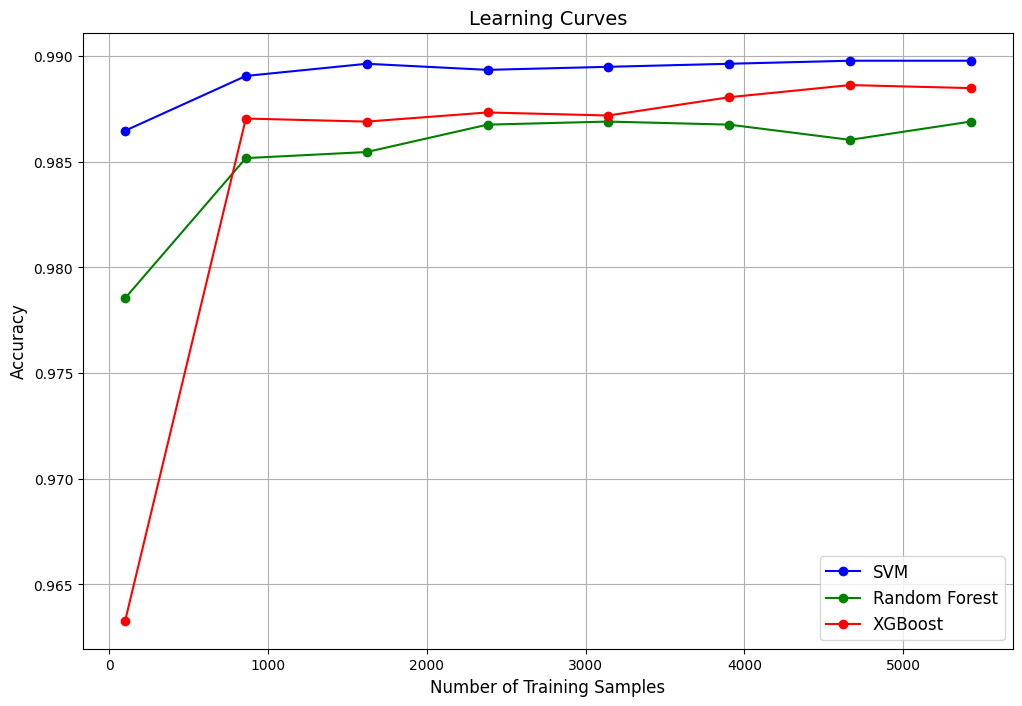

In [28]:
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve

def plotCombinedLearningCurves(xTrain, yTrain, svmModel, rfModel, xgbModel):
    # Create Visualization directory if it doesn't exist
    visualizationDir = os.path.join(os.path.dirname(os.getcwd()), 'Visualization')
    if not os.path.exists(visualizationDir):
        os.makedirs(visualizationDir)

    max_samples = len(xTrain)
    trainSizes = np.linspace(100, max_samples, 10, dtype=int)
    trainSizes = trainSizes[trainSizes <= 5556]  # Ensure values are within allowed range

    # SVM
    _, svm_trainScores, svm_valScores = learning_curve(svmModel, xTrain, yTrain, train_sizes=trainSizes, cv=5, scoring='accuracy', n_jobs=-1)
    svm_trainMean = np.mean(svm_trainScores, axis=1)
    svm_valMean = np.mean(svm_valScores, axis=1)
    
    # Random Forest
    _, rf_trainScores, rf_valScores = learning_curve(rfModel, xTrain, yTrain, train_sizes=trainSizes, cv=5, scoring='accuracy', n_jobs=-1)
    rf_trainMean = np.mean(rf_trainScores, axis=1)
    rf_valMean = np.mean(rf_valScores, axis=1)
    
    # XGBoost
    _, xgb_trainScores, xgb_valScores = learning_curve(xgbModel, xTrain, yTrain, train_sizes=trainSizes, cv=5, scoring='accuracy', n_jobs=-1)
    xgb_trainMean = np.mean(xgb_trainScores, axis=1)
    xgb_valMean = np.mean(xgb_valScores, axis=1)
    
    plt.figure(figsize=(12, 8))
    plt.plot(trainSizes, svm_valMean, 'o-', color="blue", label="SVM")
    plt.plot(trainSizes, rf_valMean, 'o-', color="green", label="Random Forest")
    plt.plot(trainSizes, xgb_valMean, 'o-', color="red", label="XGBoost")
    plt.title("Learning Curves", fontsize=14)
    plt.xlabel("Number of Training Samples", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.legend(loc="best", fontsize=12)
    plt.grid(True)

    # Save the figure
    plt.savefig(os.path.join(visualizationDir, 'learningCurves.png'), dpi=300, bbox_inches='tight')
    plt.show()

plotCombinedLearningCurves(xTrain, yTrain, svmModel, rfModel, xgbModel)

## Hyperparametrien vaikutukset

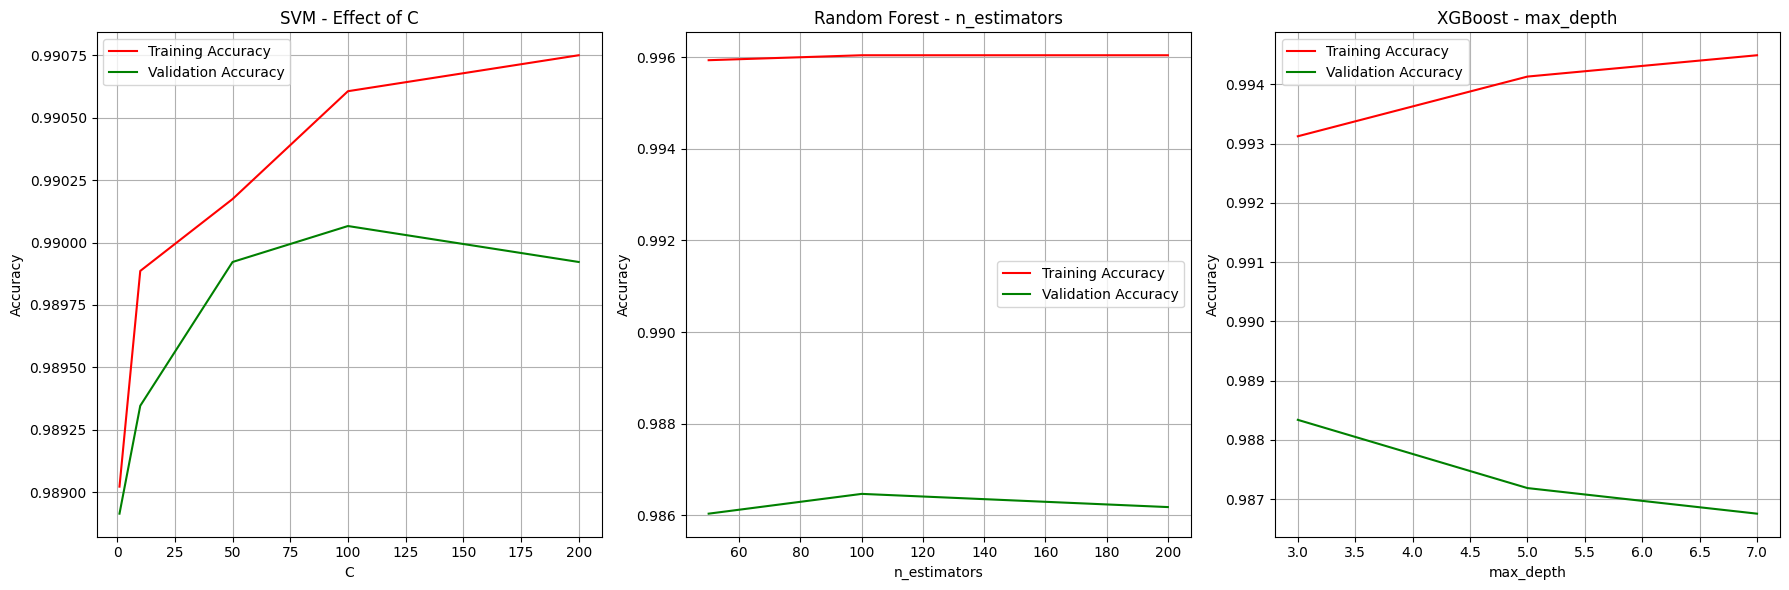

In [29]:
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import validation_curve
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

def plotHyperparameterEffects(xTrain, yTrain):
    # Create Visualization directory if it doesn't exist
    visualizationDir = os.path.join(os.path.dirname(os.getcwd()), 'Visualization')
    if not os.path.exists(visualizationDir):
        os.makedirs(visualizationDir)

    # SVM
    svm_param_range = [1, 10, 50, 100, 200]
    trainScores, valScores = validation_curve(SVC(), xTrain, yTrain, param_name="C", param_range=svm_param_range, cv=5, scoring="accuracy", n_jobs=-1)
    svm_trainMean = np.mean(trainScores, axis=1)
    svm_valMean = np.mean(valScores, axis=1)

    # Random Forest
    rf_param_range = [50, 100, 200]
    trainScores, valScores = validation_curve(RandomForestClassifier(), xTrain, yTrain, param_name="n_estimators", param_range=rf_param_range, cv=5, scoring="accuracy", n_jobs=-1)
    rf_trainMean = np.mean(trainScores, axis=1)
    rf_valMean = np.mean(valScores, axis=1)

    # XGBoost
    xgb_param_range = [3, 5, 7]
    trainScores, valScores = validation_curve(XGBClassifier(eval_metric='mlogloss'), xTrain, yTrain, param_name="max_depth", param_range=xgb_param_range, cv=5, scoring="accuracy", n_jobs=-1)
    xgb_trainMean = np.mean(trainScores, axis=1)
    xgb_valMean = np.mean(valScores, axis=1)

    # Plotting
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.plot(svm_param_range, svm_trainMean, label="Training Accuracy", color='r')
    plt.plot(svm_param_range, svm_valMean, label="Validation Accuracy", color='g')
    plt.title("SVM - Effect of C")
    plt.xlabel("C")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(rf_param_range, rf_trainMean, label="Training Accuracy", color='r')
    plt.plot(rf_param_range, rf_valMean, label="Validation Accuracy", color='g')
    plt.title("Random Forest - n_estimators")
    plt.xlabel("n_estimators")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(xgb_param_range, xgb_trainMean, label="Training Accuracy", color='r')
    plt.plot(xgb_param_range, xgb_valMean, label="Validation Accuracy", color='g')
    plt.title("XGBoost - max_depth")
    plt.xlabel("max_depth")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.grid(True)

    plt.tight_layout()

    # Save the figure
    plt.savefig(os.path.join(visualizationDir, 'hyperparameterEffects.png'), dpi=300, bbox_inches='tight')
    plt.show()

plotHyperparameterEffects(xTrain, yTrain)

## Confusionmatrix

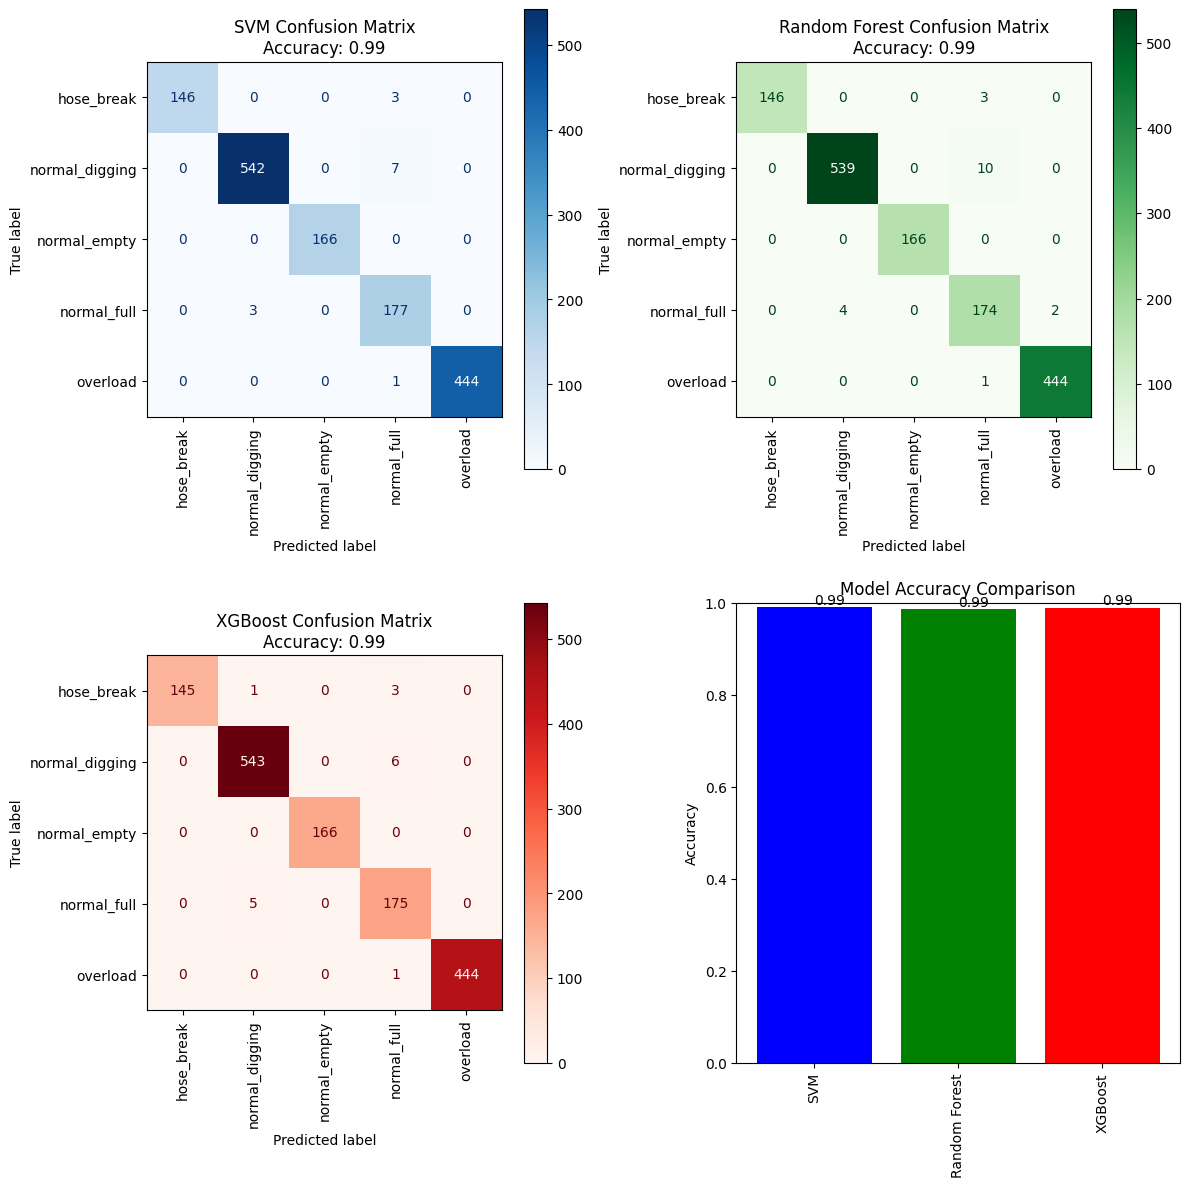

In [30]:
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

def plotModelComparisons(xTest, yTest, svmModel, rfModel, xgbModel, classNames):
    # Create Visualization directory if it doesn't exist
    visualizationDir = os.path.join(os.path.dirname(os.getcwd()), 'Visualization')
    if not os.path.exists(visualizationDir):
        os.makedirs(visualizationDir)

    # Predictions
    svm_pred = svmModel.predict(xTest)
    rf_pred = rfModel.predict(xTest)
    xgb_pred = xgbModel.predict(xTest)

    # Confusion matrices
    svm_cm = confusion_matrix(yTest, svm_pred)
    rf_cm = confusion_matrix(yTest, rf_pred)
    xgb_cm = confusion_matrix(yTest, xgb_pred)

    # Accuracies
    svm_accuracy = accuracy_score(yTest, svm_pred)
    rf_accuracy = accuracy_score(yTest, rf_pred)
    xgb_accuracy = accuracy_score(yTest, xgb_pred)

    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))

    # SVM confusion matrix
    disp = ConfusionMatrixDisplay(svm_cm, display_labels=classNames)
    disp.plot(ax=axes[0, 0], cmap='Blues', xticks_rotation=90)
    axes[0, 0].set_title(f"SVM Confusion Matrix\nAccuracy: {svm_accuracy:.2f}")

    # Random Forest confusion matrix
    disp = ConfusionMatrixDisplay(rf_cm, display_labels=classNames)
    disp.plot(ax=axes[0, 1], cmap='Greens', xticks_rotation=90)
    axes[0, 1].set_title(f"Random Forest Confusion Matrix\nAccuracy: {rf_accuracy:.2f}")

    # XGBoost confusion matrix
    disp = ConfusionMatrixDisplay(xgb_cm, display_labels=classNames)
    disp.plot(ax=axes[1, 0], cmap='Reds', xticks_rotation=90)
    axes[1, 0].set_title(f"XGBoost Confusion Matrix\nAccuracy: {xgb_accuracy:.2f}")

    # Model accuracy comparison
    bars = axes[1, 1].bar(['SVM', 'Random Forest', 'XGBoost'], [svm_accuracy, rf_accuracy, xgb_accuracy], color=['blue', 'green', 'red'])
    axes[1, 1].set_ylim(0, 1)
    axes[1, 1].set_title("Model Accuracy Comparison")
    axes[1, 1].set_ylabel("Accuracy")
    axes[1, 1].set_xticklabels(['SVM', 'Random Forest', 'XGBoost'], rotation=90)

    # Add accuracy values on top of bars
    for bar in bars:
        yval = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f}", va='bottom')

    plt.tight_layout()

    # Save the figure
    plt.savefig(os.path.join(visualizationDir, 'modelComparisons.png'), dpi=300, bbox_inches='tight')
    plt.show()

plotModelComparisons(xTest, yTest, svmModel, rfModel, xgbModel, classNames)